# Floor detector

This notebook looks at the results of the BRAILS module `NFloorDetector` against data that was scraped from the
[Miami-Dade Property Search](https://www.miamidade.gov/Apps/PA/propertysearch/) web application.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use("typewriter")

from scripts.plotting import plot_confusion_matrix
import sklearn.metrics
import pandas as pd

## Configuration

In [2]:
WRITE = True
MODEL = "floors"
SEP = "\t" # write out data in TSV format for easy command line processing.
outdir = Path("./out/")
CONF_THRESH = 0.9
label_keys = list(map(int,range(1,5)))
label_file = "labels/scrape.tsv"
pred_file = "models/nFloorPredict.csv"

## Data processing

In [3]:
preds = pd.read_csv(pred_file, header=0, names=["image", "prediction"])
preds["image"] = preds["image"].apply(lambda x: str(Path(x).name + ".png"))
preds = preds.set_index("image")

In [4]:
labels = pd.read_csv(
    label_file,
    sep="\t",
    names=["coords","address","folio","occupancy","floors","year"],index_col=False,
    header=None
)

In [5]:
labels["image"] = labels["coords"].apply(lambda c: f"StreetViewx{c.split(',')[1]}x{c.split(',')[0]}.png")

In [6]:
# labels["label"] = labels["floors"]
labels = labels.set_index("image").drop(columns=["address","folio","coords"])
labels = labels.join(preds)
if WRITE:
    labels.to_csv(outdir / f"{MODEL}.ipynb.tsv", sep=SEP)
labels["floors"] = labels["floors"].apply(float)

## Filter out NaNs

In [7]:
labels = labels[labels["prediction"]>0]
labels

,occupancy,floors,year,prediction
image,,,,
StreetViewx-80.245495x25.699935.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,3.0,1990,1.0
StreetViewx-80.246676x25.708025.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,2.0,1952,1.0
StreetViewx-80.247784x25.708372.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,2.0,1960,1.0
StreetViewx-80.247784x25.708372.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,2.0,1960,1.0
StreetViewx-80.265499x25.732245.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,1.0,1984,1.0
...,...,...,...,...
StreetViewx-80.422335x25.467288.png,RESIDENTIAL - SINGLE FAMILY : ADDITIONAL LIVIN...,2.0,2014,1.0
StreetViewx-80.422687x25.468644.png,RESIDENTIAL - SINGLE FAMILY : CLUSTER HOME,1.0,2013,1.0
StreetViewx-80.423414x25.469666.png,RESIDENTIAL - SINGLE FAMILY : CLUSTER HOME,1.0,0,1.0


## Build confusion matrix

In [8]:
print(len(labels))

1958


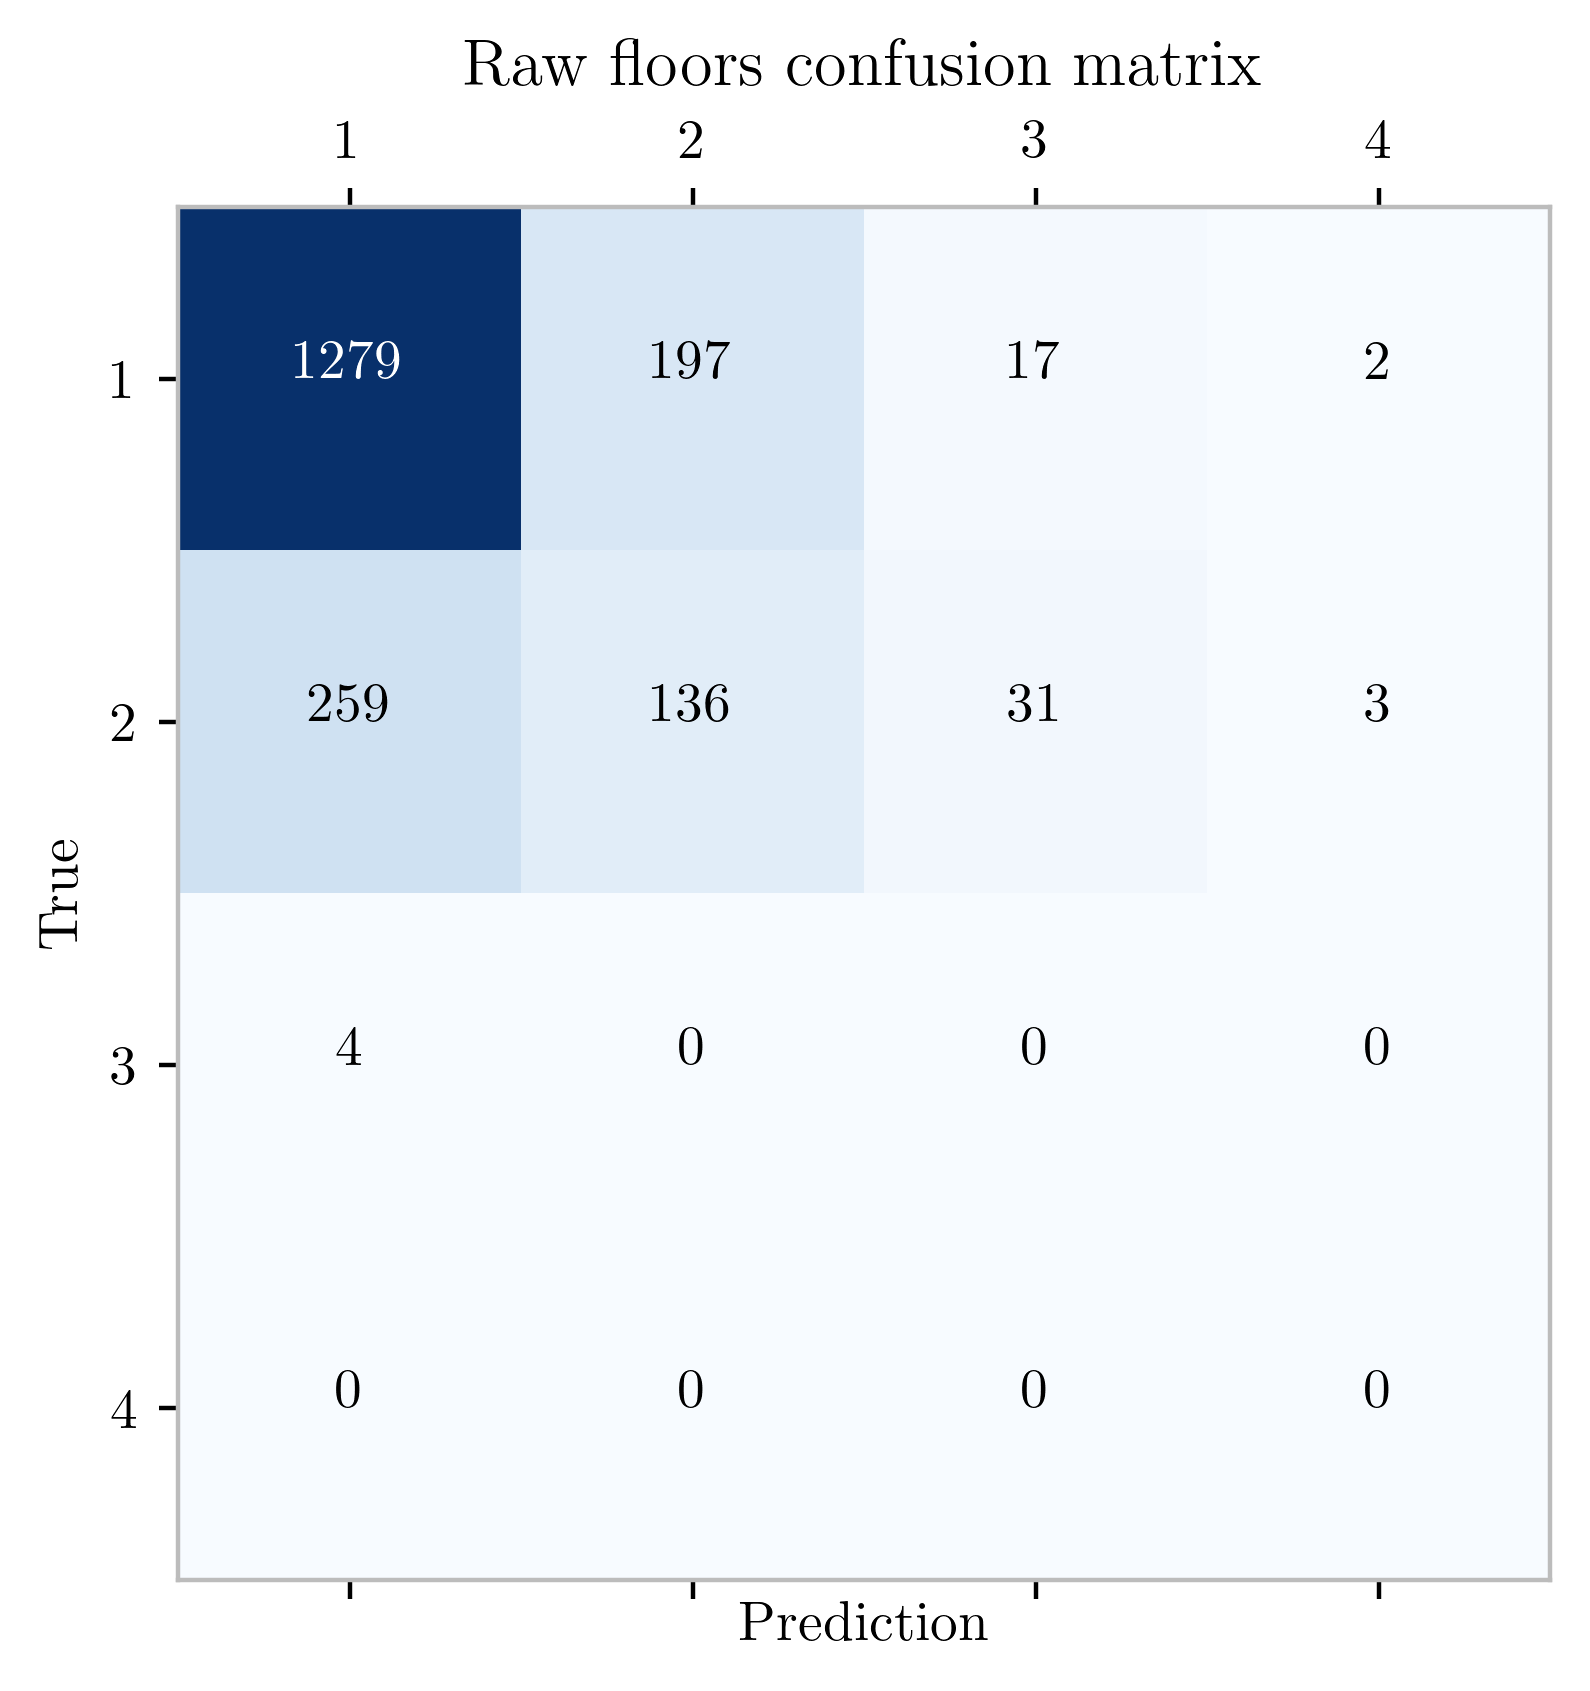

In [9]:
cmatrix = sklearn.metrics.confusion_matrix(labels["floors"], labels["prediction"], labels=label_keys)
ax_raw = plot_confusion_matrix(cmatrix,label_keys)
ax_raw.set_xticks(range(len(label_keys)))
ax_raw.set_xticklabels(label_keys)
ax_raw.set_yticks(range(len(label_keys)))
ax_raw.set_yticklabels(label_keys);
ax_raw.set_ylabel("True")
ax_raw.set_ylabel("True")
ax_raw.set_title(f"Raw {MODEL} confusion matrix")
if WRITE:
    ax_raw.figure.savefig(f"docs/{MODEL}-conf-raw.png")

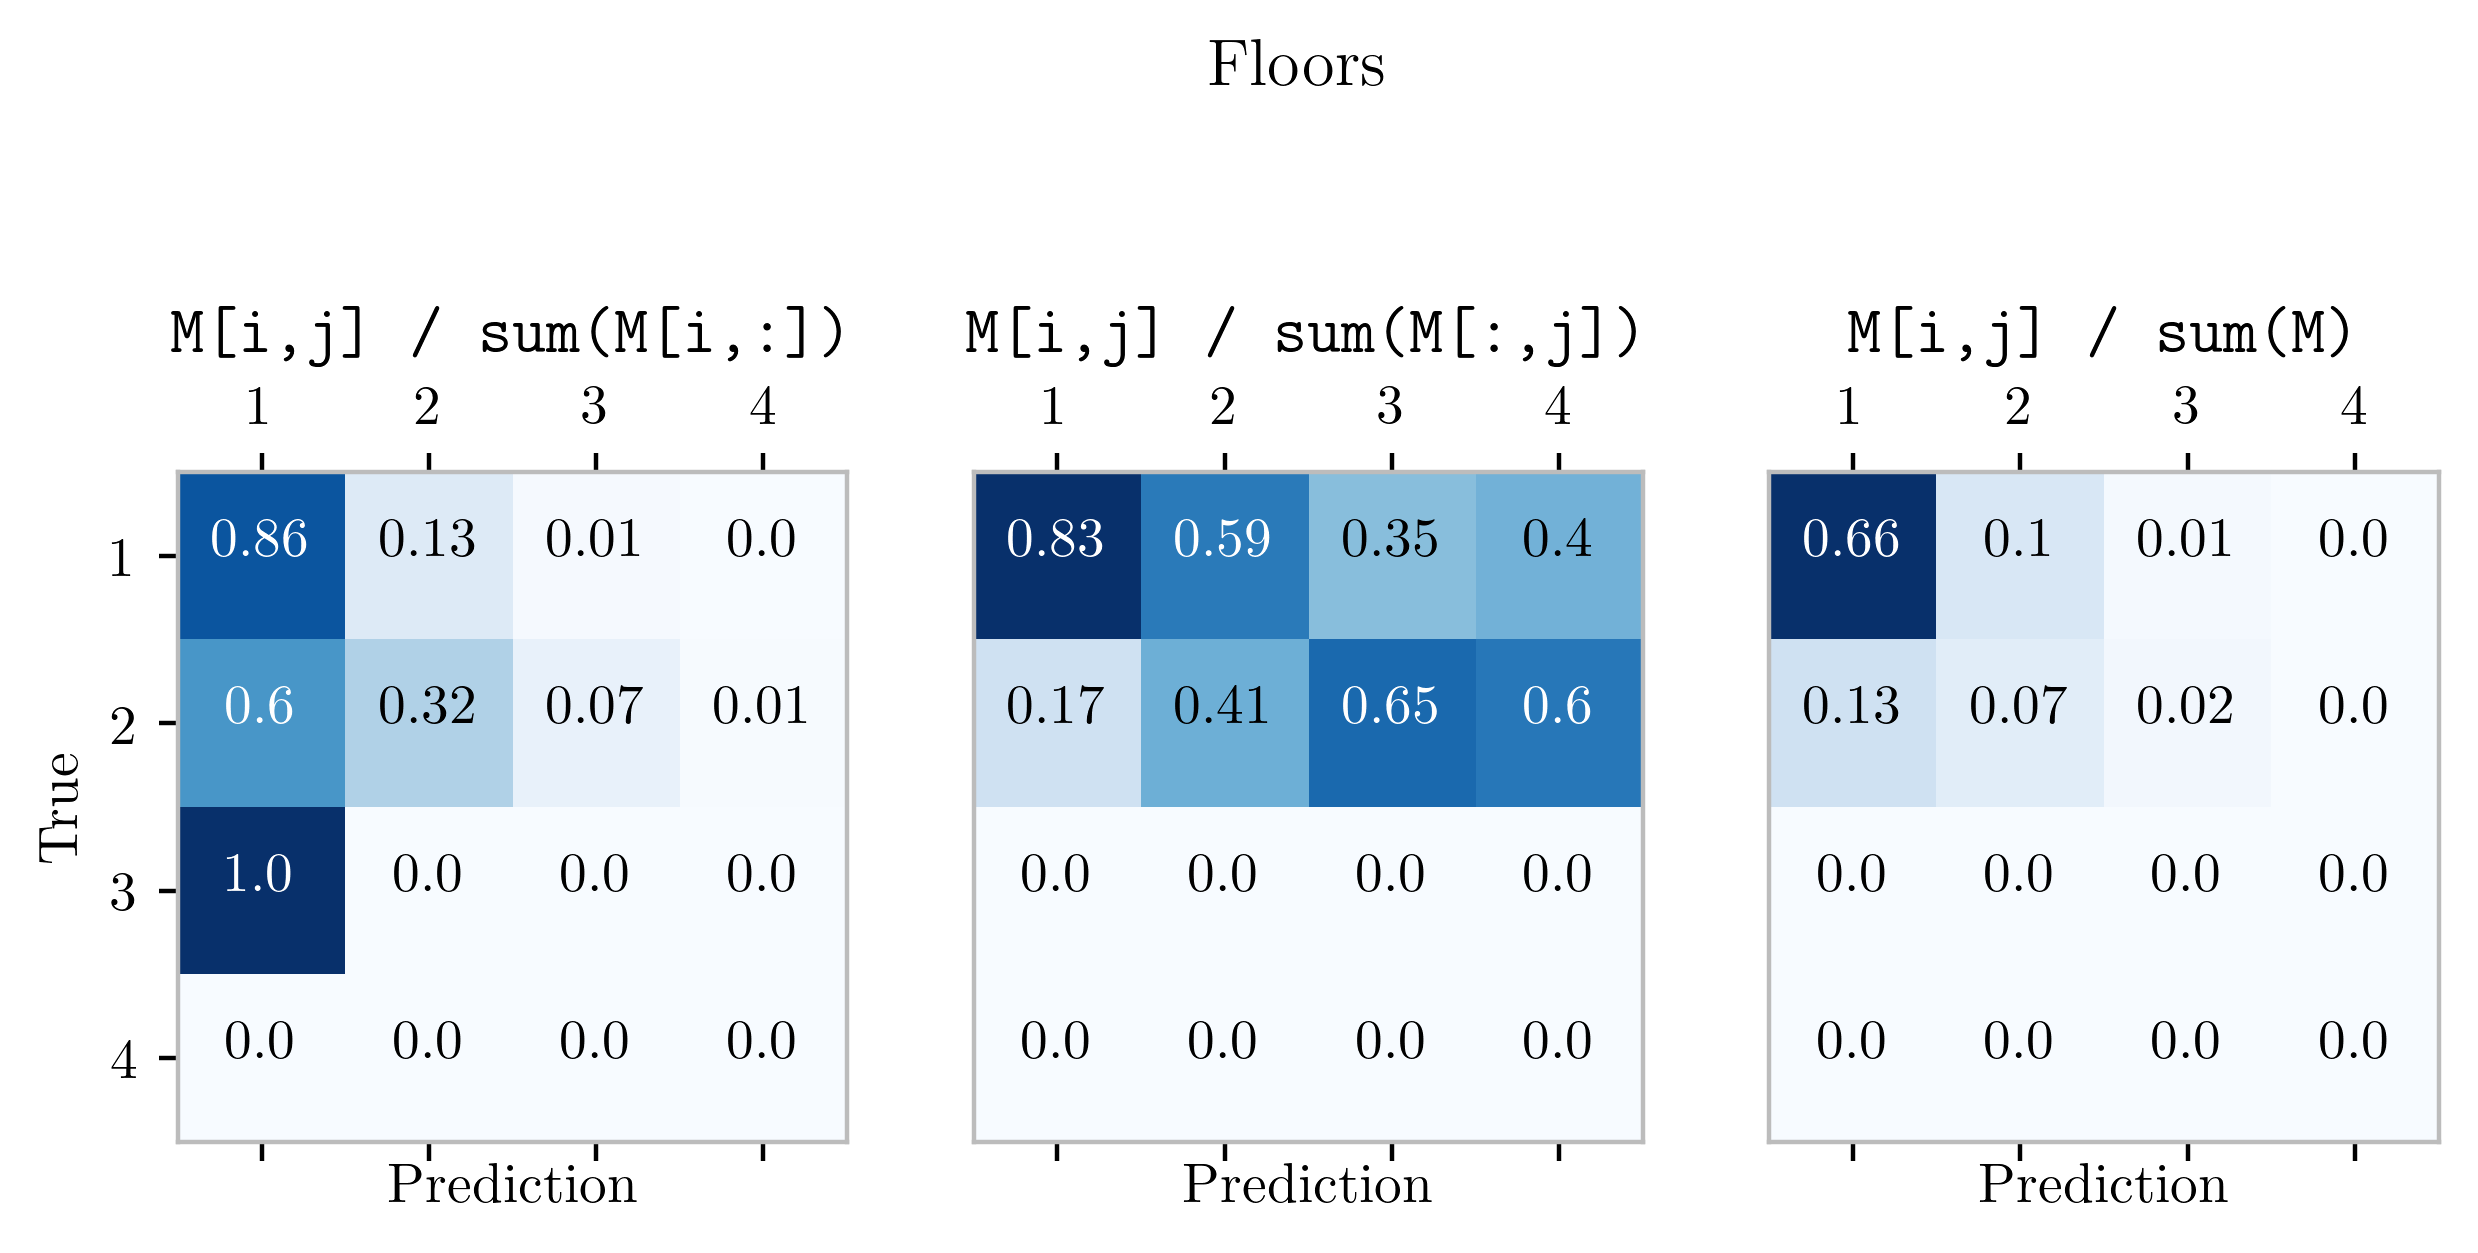

In [10]:
norms = ["true", "pred", "all"]
names = ["M[i,j] / sum(M[i,:])", "M[i,j] / sum(M[:,j])", "M[i,j] / sum(M)"]

fig, ax = plt.subplots(1,len(norms))
for i,norm in enumerate(norms):
    cmatrix = sklearn.metrics.confusion_matrix(labels["floors"], labels["prediction"], labels=label_keys, normalize=norm)
#     cmatrix = sklearn.metrics.confusion_matrix(labels["label"], labels["prediction"],normalize=norm)
    plot_confusion_matrix(cmatrix,label_keys, ax=ax[i], title=f"\\texttt{{{names[i]}}}")
    ax[i].set_xticks(range(len(label_keys)))
    ax[i].set_xticklabels(label_keys)
    ax[i].get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].set_yticks(range(len(label_keys)))
ax[0].set_yticklabels(label_keys);
ax[0].set_ylabel("True")

fig.suptitle(f"{MODEL[0].upper() + MODEL[1:]}")

if WRITE:
    fig.savefig(f"docs/{MODEL}-conf.png")